## Tema 3: Naive-bayes y KNN Aprendizaje automático

### Autor: José Miguel

### Prácticas Naive Bayes y KNN (ejercicio 1)

##### **1. Tomando como base este [tutorial](https://colab.research.google.com/drive/1zFIOfrceEaFkhQOEOkMWroBmNV1HAMVS?usp=drive_link),  crea un modelo de clasificación usando KNN con los mismos datos sintéticos. Para la elección de los mejores hiperparámetros usa un sistema de [validación cruzada](https://educacionadistancia.juntadeandalucia.es/centros/cordoba/pluginfile.php/406946/mod_resource/content/1/M2_SAA_S10%20-%20Validaci%C3%B3n.pdf).**



#### 1. Generación de datos sintéticos
Generaremos unos datos sintéticos para el ejemplo propuesto, con la misma semilla.

#### 1.1 Generamos los datos sintéticos

Creamos dos arrays bidimensionales:

- En el primero los datos seguirán una distribución normal de media 0 y desviación estándar 1. Representarán a la Clase_0.
- En el segundo los datos seguirán una distribución normal de media 3 y desviación estándar 1. Representarán a la Clase_1.

In [105]:
import numpy as np
import pandas as pd

# cada vez que ejecutes funciones de generación de números aleatorios obtendrás la misma secuencia de números aleatorios. 
np.random.seed(41)

# Clase_0. Distribución normal de media 0 y desviación estándar 1
class_0_data = np.random.normal(0, 1, size=(100, 2))
class_0_labels = np.zeros(100) # Representación de etiquetas como ceros

# Clase_1. Distribución normal de media 3 y desviación estándar 1
class_1_data = np.random.normal(3, 1, size=(100, 2))
class_1_labels = np.ones(100) # Representación de etiquetas como unos

#### 2. Carga de los datos en dataframe

In [106]:
# Formatear los datos, combinar datos de ambas clases
X = np.vstack((class_0_data, class_1_data))
y = np.concatenate((class_0_labels, class_1_labels))

"""
vstack: para apilar verticalmente los datos
concatenate: para concatenar los datos
"""

# Crearemos 2 dataframes uno para las clases y otro para las caracteristicas
df_clases = pd.DataFrame(X, columns=['Clase_0', 'Clase_1'])
df_target = pd.DataFrame(y, columns=['Target'])

# Otra forma de crear el dataset con las filas y columnas
# df_data = pd.DataFrame(data= np.c_[X, y], columns=['Clase_0', 'Clase_1', 'Target'])

# Concatenemos los 2 dataframes y el target lo pasamos a tipo int para knn.
df_final = pd.concat([df_clases, df_target], axis=1)
df_final.Target = df_final.Target.astype(int)
df_final

,Clase_0,Clase_1,Target
0,-0.270712,0.104848,0
1,0.250528,-0.925200,0
2,0.567144,-1.040180,0
3,-0.153676,0.789852,0
4,-1.226216,-0.948007,0
...,...,...,...
195,3.754550,4.091037,1
196,3.957150,3.399005,1
197,1.118678,2.318888,1
198,4.010052,3.822308,1


In [107]:
# comprobamos que el target sea único y tenga sólo 0 y 1
df_final['Target'].unique()

array([0, 1])

#### 3. Selección de variables

Usaremos un mapa de calor para ver la correlación entre la variable a predecir y cada una de las características.

,Clase_0,Clase_1,Target
Clase_0,1.000000,0.711657,0.810961
Clase_1,0.711657,1.000000,0.861755
Target,0.810961,0.861755,1.000000


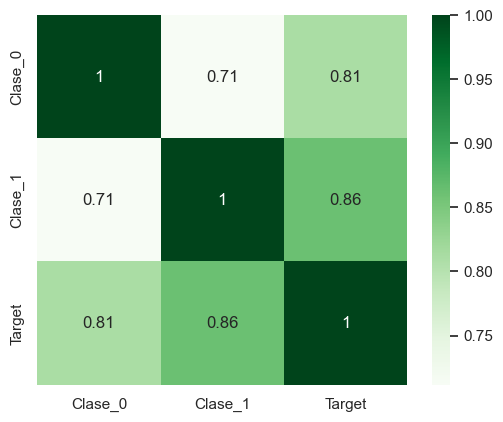

In [108]:
import seaborn as sns

sns.set()
sns.heatmap(df_final.corr(), square=True, annot=True, cmap='Greens')

# Las variables con una correlación cercana a 1 tienen una correlación positiva fuerte,
# mientras que las variables con una correlación cercana a -1 tienen una correlación negativa fuerte.
# Si la correlación está cerca de 0, las variables están débilmente correlacionadas.
# Normalmente la correlación se hace cuando hay más de 3 variables y queremos quedarnos
# con las menos posibles para ahorrar coste computacional.

df_final.corr()

#### 4. Parametrización y validación Cruzada

In [109]:
# Dividiremos el df_final en un conjunto de datos de test y entrenamiento 33% test y 67% entrenamiento
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.33

train, test = train_test_split(df_final, test_size = TEST_SIZE)
# sino quitamos datos no hace falta ajustar los indíces
# sino pongo el implace = true me devuelve un nuevo dataframe
train.reset_index(inplace = True)
test.reset_index(inplace = True)
train

,index,Clase_0,Clase_1,Target
0,8,-0.609778,1.469416,0
1,19,-0.818308,-0.962384,0
2,138,1.548087,3.921564,1
3,173,4.853147,5.114540,1
4,185,2.514818,2.385031,1
...,...,...,...,...
129,90,-1.234605,1.470797,0
130,121,1.607519,3.988415,1
131,155,4.514982,3.480295,1
132,133,2.853887,1.907700,1


Usaremos ahora el algortimo de **KNeighbors/Radius**. Me he decantado por usar el de k vecinos más cercanos.

Max Value uniform : 1.0 (1)
Max Value distance : 1.0 (1)


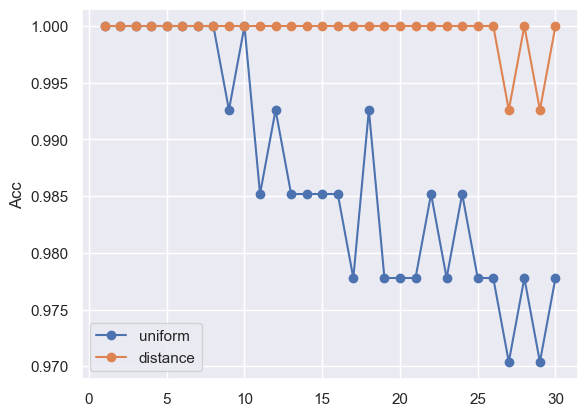

In [110]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

MIN_NEIGHBORDS = 1
MAX_NEIGHBORDS = 30
N_SPLITS = 5 # nº de particiones

# Validación cruzada cv
cv = KFold(n_splits = N_SPLITS, shuffle = False) # shuffle = mezcla datos y entrena si está a true

for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []

    for n_neighbors in range(MIN_NEIGHBORDS,MAX_NEIGHBORDS+1):
        fold_accuracy = []
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        for train_fold, test_fold in cv.split(train):
            # División train test aleatoria
            f_train = train.loc[train_fold]
            f_test = train.loc[test_fold]

            # entrenamiento y ejecución del modelo
            knn.fit(X = f_train.drop(['Target'], axis=1),
                            y = f_train['Target'])
            y_pred = knn.predict(X = f_test.drop(['Target'], axis = 1))

            # evaluación del modelo
            acc = accuracy_score(f_test['Target'], y_pred)
            fold_accuracy.append(acc)

        total_scores.append(np.mean(fold_accuracy))
        #total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

    plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
    print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('Acc')

plt.legend()
plt.show()

En este caso nos da lo mismo quedarnos con el valor de uniform o distance, ya que es el mismo valor.

#### 5. Construcción y análisis del modelo con el hiperparámetro distancia.

Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos a graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

In [111]:
# Seleccionamos la mejor parametrización obtenida
N_NEIGHBORS = 3
WEIGHTS = 'distance'
knn = neighbors.KNeighborsClassifier(n_neighbors = N_NEIGHBORS, weights = WEIGHTS)
y_test = test['Target']

# fit and predict
"""
fit: para entrenar el modelo
predict: para ejecutar el modelo
accuracy_score: para obtener la precisión del modelo
"""
knn.fit(X = train[['Clase_0','Clase_1']], y = train['Target'])
y_pred = knn.predict(X = test[['Clase_0','Clase_1']])
acc = accuracy_score(y_test, y_pred)
print('Acc', acc)

Acc 0.9393939393939394


#### 6. Visualizamos la Matriz de Confusión y los resultados

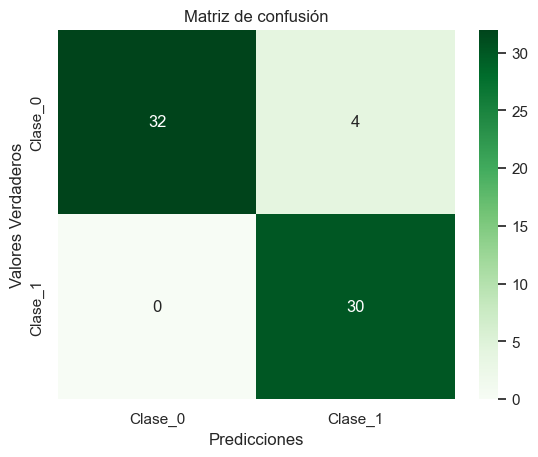

In [112]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
classes = ('Clase_0', 'Clase_1') # 0 y 1 los valores del unique
sns.heatmap(cm, annot=True, cmap='Greens', xticklabels=classes, yticklabels=classes) 
# x_ticklabels y y_ticklabels para poner las etiquetas del eje x e y
# annot = true para que los valores reales de la matriz (cm) se muestren en cada celda del mapa de calor.
plt.title('Matriz de confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Interpretación de los resultados de la matriz de confusión:

- Verdaderos Positivos (TP): 32
- Falsos Positivos (FP): 4
- Falsos Negativos (FN): 0
- Verdaderos Negativos (TN): 30